In [2]:
# Config & helpers (multi-refs)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import nnls

# ---------- Paths ----------
data_folder = "../data/test/spot1"             # measured mixture spectra (.CSV)
ref_folder  = "../data/refs"           
out_folder  = "../results"
plot_dir    = "../plots"
os.makedirs(out_folder, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# ---------- Reference subfolders ----------
ptfe_ref_dir = os.path.join(ref_folder, "ptfe_100")
hbn_ref_dir  = os.path.join(ref_folder, "hbn_thin_100")

# Profile file (scan coordinates, no header: col0=X, col1=Y)
profile_path  = "../data/test/profile/profile1.CSV"

# ---------- CLS physics & options ----------
baseline_term    = False   # include constant baseline column in S
use_arealmass    = True    # normalize refs by areal mass (thickness × density)

# Reference film parameters (adjust as needed)
thickness_ptfe_um = 200.0   # µm
rho_ptfe_g_cm3    = 2.20    # g/cm^3
thickness_hbn_um  = 540.0  # µm (updated for thin pellet)
rho_hbn_g_cm3     = 0.3    # g/cm^3 (updated for thin pellet)

# ---------- Helpers ----------
def run_id_from_filename(fn: str) -> int:
    """Extract trailing integer before extension (…_001.CSV → 1)."""
    m = re.search(r'(\d+)(?=\.[Cc][Ss][Vv]$)', os.path.basename(fn))
    if not m:
        raise ValueError(f"Cannot parse trailing digits: {fn}")
    return int(m.group(1))

def load_spectrum_csv(path: str):
    """Load 2-column CSV (wavenumber, absorbance)."""
    df = pd.read_csv(path, header=None)
    wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
    ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
    m  = ~(np.isnan(wn) | np.isnan(ab))
    return wn[m], ab[m]

def load_and_interp_many(folder, wn_grid):
    """Load all CSV in a folder and interpolate to wn_grid."""
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".csv")])
    spectra = []
    for path in files:
        wn, ab = load_spectrum_csv(path)
        ab_g   = interp1d(wn, ab, kind="linear", fill_value="extrapolate")(wn_grid)
        spectra.append(ab_g)
    return np.array(spectra)


In [3]:
# Load profile (X,Y) and build sorted sample file list

profile = pd.read_csv(profile_path, header=None, usecols=[0,1], names=["X","Y"])

# list and sort sample files by numeric suffix so X[i] ↔ profile.iloc[i]
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.lower().endswith(".csv")]
files_sorted = sorted(all_files, key=run_id_from_filename)

if len(files_sorted) != len(profile):
    raise ValueError(f"Count mismatch: {len(files_sorted)} sample files vs {len(profile)} profile rows.")

N = len(files_sorted)
print("N spectra:", N)
display(profile.head())


N spectra: 100


,X,Y
0,-8742.801,2796.128
1,-8642.801,2796.128
2,-8542.801,2796.128
3,-8442.801,2796.128
4,-8342.800,2796.128


In [4]:
# Load all PTFE and h-BN references, normalize, build multi-ref basis

from glob import glob

# Pick first file in each folder to set grid
ptfe_first = sorted(glob(os.path.join(ptfe_ref_dir, "*.CSV")))[0]
hbn_first  = sorted(glob(os.path.join(hbn_ref_dir,  "*.CSV")))[0]

wn_ptfe0, _ = load_spectrum_csv(ptfe_first)
wn_hbn0,  _ = load_spectrum_csv(hbn_first)

# Common wavenumber grid
wn_min = max(np.min(wn_ptfe0), np.min(wn_hbn0))
wn_max = min(np.max(wn_ptfe0), np.max(wn_hbn0))
wn_grid = np.linspace(wn_min, wn_max, 1725)

# Load and interpolate all refs
ptfe_refs = load_and_interp_many(ptfe_ref_dir, wn_grid)
hbn_refs  = load_and_interp_many(hbn_ref_dir,  wn_grid)
print("PTFE refs:", ptfe_refs.shape, "| hBN refs:", hbn_refs.shape)

# Areal-mass normalization
if use_arealmass:
    t_ptfe_cm = thickness_ptfe_um * 1e-4
    t_hbn_cm  = thickness_hbn_um  * 1e-4
    mA_ptfe   = max(rho_ptfe_g_cm3 * t_ptfe_cm, 1e-12)
    mA_hbn    = max(rho_hbn_g_cm3  * t_hbn_cm,  1e-12)
    ptfe_refs = ptfe_refs / mA_ptfe
    hbn_refs  = hbn_refs  / mA_hbn
else:
    ptfe_refs = ptfe_refs / (np.max(np.abs(ptfe_refs), axis=1)[:,None] + 1e-12)
    hbn_refs  = hbn_refs  / (np.max(np.abs(hbn_refs),  axis=1)[:,None] + 1e-12)

# Multi-reference design matrix
S_multi = np.vstack([ptfe_refs, hbn_refs]).T
if baseline_term:
    S_multi = np.column_stack([S_multi, np.ones_like(wn_grid)])

n_ptfe, n_hbn = ptfe_refs.shape[0], hbn_refs.shape[0]
print("Design matrix shape:", S_multi.shape, "| PTFE refs:", n_ptfe, "| hBN refs:", n_hbn)


PTFE refs: (100, 1725) | hBN refs: (100, 1725)
Design matrix shape: (1725, 200) | PTFE refs: 100 | hBN refs: 100


In [5]:
# Load all sample spectra and interpolate to wn_grid

X = np.zeros((N, len(wn_grid)), dtype=float)
file_names = []

for i, fpath in enumerate(files_sorted):
    w, a = load_spectrum_csv(fpath)
    a_g  = interp1d(w, a, kind="linear", fill_value="extrapolate")(wn_grid)
    X[i] = a_g
    file_names.append(os.path.basename(fpath))

print("X shape:", X.shape)


X shape: (100, 1725)


In [6]:
# Apply CLS (NNLS) with multi-reference basis

IMPURITY_THRESHOLD = 0.5  # % h-BN

K = S_multi.shape[1]
coef = np.zeros((N, K), dtype=float)
fit  = np.zeros_like(X)

for i in range(N):
    c, _ = nnls(S_multi, X[i])
    coef[i] = c
    fit[i]  = S_multi @ c

# Split coefficients: sum within each component group
ptfe_w = coef[:, :n_ptfe].sum(axis=1)
hbn_w  = coef[:, n_ptfe:n_ptfe+n_hbn].sum(axis=1)

den = np.maximum(ptfe_w + hbn_w, 1e-12)
hbn_percent_cls = 100.0 * (hbn_w / den)
is_impurity     = (hbn_percent_cls >= IMPURITY_THRESHOLD).astype(int)

# Pack results
out_cls = pd.DataFrame({
    "index": np.arange(1, N+1, dtype=int),
    "file": file_names,
    "X": profile["X"].to_numpy(),
    "Y": profile["Y"].to_numpy(),
    "hbn_percent_cls": hbn_percent_cls,
    "is_impurity": is_impurity
})
export_path = os.path.join(out_folder, "test_cls_spot1.csv")
out_cls.to_csv(export_path, index=False)
print("Saved:", export_path)
display(out_cls.head())


Saved: ../results/test_cls_spot1.csv


,index,file,X,Y,hbn_percent_cls,is_impurity
0,1,2025_9_11_14_49_60001.CSV,-8742.801,2796.128,0.000000,0
1,2,2025_9_11_14_49_60002.CSV,-8642.801,2796.128,0.000000,0
2,3,2025_9_11_14_49_60003.CSV,-8542.801,2796.128,0.523601,1
3,4,2025_9_11_14_49_60004.CSV,-8442.801,2796.128,1.400594,1
4,5,2025_9_11_14_49_60005.CSV,-8342.800,2796.128,6.922446,1


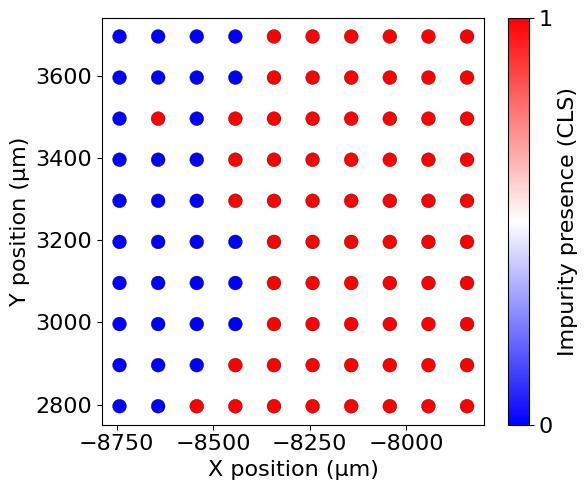

Saved: ../plots/fig5e.jpg


In [7]:
# Binary impurity map 

from matplotlib.ticker import MaxNLocator

# --- local style controls ---
FIGSIZE = (6, 5)
DPI     = 500
FONT    = 16
NBINS_X = 4
NBINS_Y = 5
CMAP    = "bwr"
MSIZE   = 100
EDGE_W  = 0.2

plt.figure(figsize=FIGSIZE)
sc = plt.scatter(
    out_cls["X"], out_cls["Y"],
    c=out_cls["is_impurity"],
    cmap=CMAP,
    vmin=0, vmax=1,
    s=MSIZE, edgecolor="k", linewidth=EDGE_W
)
cbar = plt.colorbar(sc, ticks=[0,1])
cbar.set_label("Impurity presence (CLS)", fontsize=FONT)
cbar.ax.tick_params(labelsize=FONT)

plt.xlabel("X position (µm)", fontsize=FONT)
plt.ylabel("Y position (µm)", fontsize=FONT)
plt.xticks(fontsize=FONT); plt.yticks(fontsize=FONT)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=NBINS_X))
ax.yaxis.set_major_locator(MaxNLocator(nbins=NBINS_Y))

plt.tight_layout()
save_path = os.path.join(plot_dir, "fig5e.jpg")
plt.savefig(save_path, dpi=DPI)
plt.show()
print("Saved:", save_path)


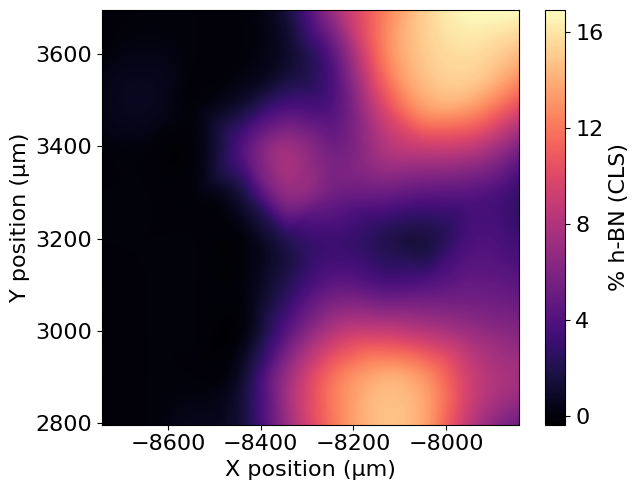

Saved: ../plots/fig5f.jpg


In [8]:
# === Heatmap from CLS percent
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from scipy.interpolate import griddata
import os

# local style controls 
FIGSIZE   = (6.5, 5)
DPI       = 500
FONT      = 16
NBINS_X   = 5
NBINS_Y   = 5
CMAP      = "magma"   # 'viridis', 'plasma', 'inferno', 'cividis', etc.
LEVELS    = 300
GRID_N    = 200       # interpolation grid resolution
SC_OVERLY = True      # overlay original points
SC_SIZE   = 20        # size of overlay points
SC_EDGE_W = 0.0       # edge width for overlay points
CB_NBINS  = 5         # ~number of colorbar ticks
CB_FMT    = "%.2f"    # colorbar label format

# --- Source data (from your scatter) ---
x = out_cls["X"].to_numpy()
y = out_cls["Y"].to_numpy()
z = out_cls["hbn_percent_cls"].to_numpy()

# --- Interpolate to grid ---
gx, gy = np.mgrid[min(x):max(x):complex(GRID_N),
                  min(y):max(y):complex(GRID_N)]
gz = griddata((x, y), z, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

# --- Plot ---
plt.figure(figsize=FIGSIZE)

# Heatmap
cs = plt.contourf(gx, gy, gz_mask, levels=LEVELS, cmap=CMAP)

# # Optional overlay of original points
# if SC_OVERLY:
#     plt.scatter(x, y, c="k", s=SC_SIZE, edgecolor="k" if SC_EDGE_W>0 else None,
#                 linewidth=SC_EDGE_W, alpha=0.7)

# Colorbar with formatting and tick control
cbar = plt.colorbar(cs)
cbar.set_label("% h-BN (CLS)", fontsize=FONT)
cbar.ax.tick_params(labelsize=FONT)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter(CB_FMT))
cbar.locator = MaxNLocator(nbins=CB_NBINS)
cbar.update_ticks()

# Axes labels and ticks
plt.xlabel("X position (µm)", fontsize=FONT)
plt.ylabel("Y position (µm)", fontsize=FONT)
plt.xticks(fontsize=FONT); plt.yticks(fontsize=FONT)

# Tick density on axes
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=NBINS_X))
ax.yaxis.set_major_locator(MaxNLocator(nbins=NBINS_Y))

plt.tight_layout()

# Save
path_heat = os.path.join(plot_dir, "fig5f.jpg")
plt.savefig(path_heat, dpi=DPI)
plt.show()
print("Saved:", path_heat)
